In [1]:
import pandas as pd
import mplfinance as mpf
from regime_detection import get_msm, identify_bull_bear_states, get_transition_counts, dating, assign_regimes
import numpy as np
from deeptime import markov
from utils import generate_ar_weights, indicator_signal
import random
import matplotlib.pyplot as plt
from trend import generate_signals, get_action_dates, plot_actions
from statsmodels.tsa.seasonal import STL

In [2]:
random.seed(42)

In [3]:
symbol = 'PFIZER'
df = pd.read_csv(f'../data/symbols/{symbol}.csv')
data = df[['close', 'date', 'returns']]
data['date'] = pd.to_datetime(df['date'])
data.set_index(data['date'], inplace=True)
data['ds_close'] = data['close'] - STL(data['close']).fit().seasonal
data['ds_dt_close'] = data['ds_close'].diff()
data.dropna(inplace=True)
data.describe()

C:\Users\adity\AppData\Local\Temp\ipykernel_27448\3862021153.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(df['date'])
C:\Users\adity\AppData\Local\Temp\ipykernel_27448\3862021153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ds_close'] = data['close'] - STL(data['close']).fit().seasonal
C:\Users\adity\AppData\Local\Temp\ipykernel_27448\3862021153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,close,returns,ds_close,ds_dt_close
count,245.000000,245.000000,245.000000,245.000000
mean,2245.309265,0.013757,2247.387558,18.977390
std,1666.488130,0.091555,1660.365322,170.994352
min,368.870000,-0.204149,391.446236,-553.455924
25%,822.040000,-0.040795,814.593267,-47.650321
50%,1780.100000,0.010763,1792.890606,9.013487
75%,3934.400000,0.057345,3952.526446,79.874043
max,6065.050000,0.573775,5811.935962,722.590848


<Axes: xlabel='date'>

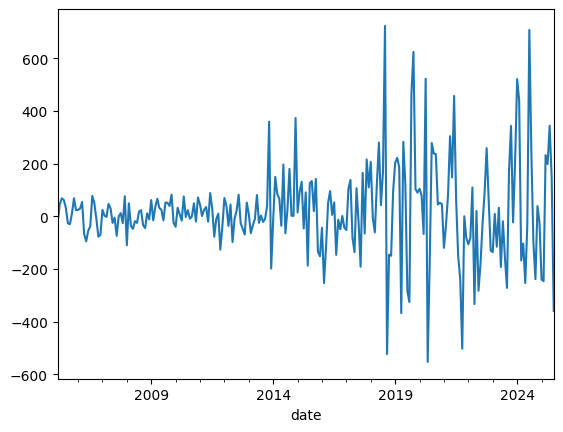

In [4]:
data['ds_dt_close'].plot()

In [5]:
split = 0.7
train_data, test_data = data[:int(split*len(data))], data[int(split*len(data)):]
test_data = test_data.reset_index(drop=True)

<Axes: xlabel='date'>

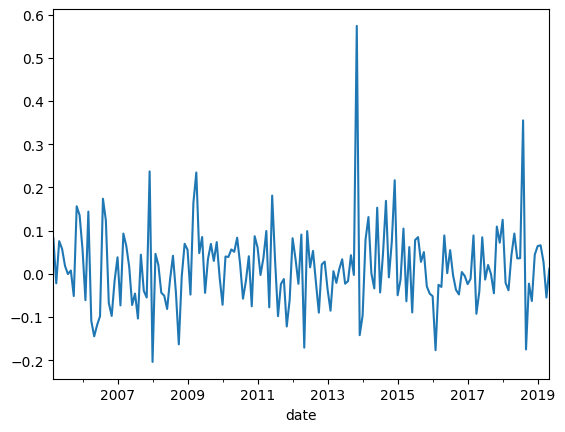

In [6]:
train_data['returns'].plot()

(array([ 7., 30., 61., 56., 12.,  3.,  0.,  1.,  0.,  1.]),
 array([-0.20414921, -0.12635684, -0.04856446,  0.02922791,  0.10702028,
         0.18481266,  0.26260503,  0.3403974 ,  0.41818977,  0.49598215,
         0.57377452]),
 <BarContainer object of 10 artists>)

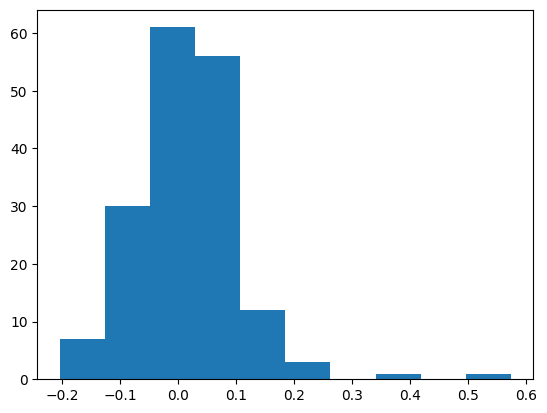

In [7]:
plt.hist(train_data['returns'])

------------------------------------------------------------
dating: original | width: 5 | min_dur: 16 | min_pha: 5
remove <P: 2007-03: 0.09>: failed alternation check
remove <T: 2008-10: -0.16>: failed alternation check
remove <T: 2011-11: -0.12>: failed alternation check
remove <P: 2012-06: 0.10>: failed alternation check
remove <T: 2014-07: -0.04>: failed alternation check
remove <T: 2015-06: -0.09>: failed alternation check
remove <T: 2017-10: -0.05>: failed alternation check
remove <P: 2018-01: 0.13>: failed alternation check
remove <P: 2005-11: 0.16>: failed duration check
remove <P: 2006-08: 0.17>: failed alternation check
remove <P: 2010-06: 0.08>: failed duration check
remove <T: 2010-01: -0.07>: failed alternation check
remove <P: 2014-12: 0.22>: failed duration check
remove <T: 2013-12: -0.14>: failed alternation check
remove <P: 2016-05: 0.09>: failed duration check
remove <T: 2016-10: -0.05>: failed alternation check
remove <P: 2017-03: 0.09>: failed duration check
remove 

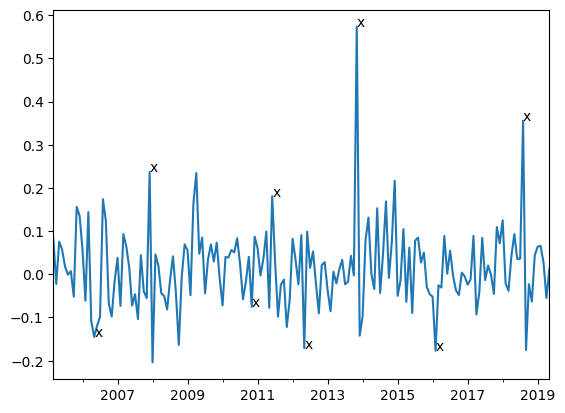

In [8]:
tp = dating(pd.Series(train_data['returns']))

In [9]:
tp

[<T: 2006-05: -0.14>,
 <P: 2007-12: 0.24>,
 <T: 2010-11: -0.08>,
 <P: 2011-06: 0.18>,
 <T: 2012-05: -0.17>,
 <P: 2013-11: 0.57>,
 <T: 2016-02: -0.18>,
 <P: 2018-08: 0.36>]

In [10]:
assign_regimes(train_data, tp)

2006-05-01 00:00:00+05:30 2006-05-01 00:00:00+05:30
2007-12-01 00:00:00+05:30 2007-12-01 00:00:00+05:30
2010-11-01 00:00:00+05:30 2010-11-01 00:00:00+05:30
2011-06-01 00:00:00+05:30 2011-06-01 00:00:00+05:30
2012-05-01 00:00:00+05:30 2012-05-01 00:00:00+05:30
2013-11-01 00:00:00+05:30 2013-11-01 00:00:00+05:30
2016-02-01 00:00:00+05:30 2016-02-01 00:00:00+05:30
7


c:\Users\adity\markov-switching-model-trading\src\regime_detection.py:527: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State'] = states


In [11]:
train_stats = train_data.groupby('State')['returns'].agg(['mean', 'std', 'count']).reset_index()
train_stats

,State,mean,std,count
0,0,0.026702,0.108999,73
1,1,0.005819,0.081591,98


In [12]:
#train_asset_states, train_stats = identify_bull_bear_states(train_data)

In [13]:
#train_asset_states

In [14]:
#train_stats

In [15]:
mu_a, mu_b = train_stats.loc[0, 'mean']*12, train_stats.loc[1, 'mean']*12
sigma_a, sigma_b = train_stats.loc[0, 'std']*(12**0.5), train_stats.loc[1, 'std']*(12**0.5)

In [16]:
transition_counts, total = get_transition_counts(train_data[['State']].reset_index())
transition_counts

[[0.958904109589041, 0.0410958904109589],
 [0.030927835051546393, 0.9690721649484536]]

In [17]:
estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

true_msm = markov.msm.MarkovStateModel(transition_counts)
trajectory = true_msm.simulate(50000)
counts_estimator = markov.TransitionCountEstimator(
    lagtime=1, count_mode="sliding"
)
counts = counts_estimator.fit(trajectory).fetch_model()
counts


TransitionCountModel-2102574188384:[{'count_matrix': array([[20119.,   883.],
                                          [  883., 28114.]]),
                                    'count_matrix_full': array([[20119.,   883.],
                                          [  883., 28114.]]),
                                    'counting_mode': 'sliding',
                                    'lagtime': 1,
                                    'state_histogram': array([21003, 28997]),
                                    'state_histogram_full': array([21003, 28997]),
                                    'state_symbols': array([0, 1])}]

In [18]:
regime_switching_model = estimator.fit(counts).fetch_model()
print("Estimated transition matrix:", regime_switching_model.transition_matrix)
print("Estimated stationary distribution:", regime_switching_model.stationary_distribution)

Estimated transition matrix: [[0.95795639 0.04204361]
 [0.03045143 0.96954857]]
Estimated stationary distribution: [0.4200484 0.5799516]


In [19]:
alpha, beta = regime_switching_model.transition_matrix[0][1], regime_switching_model.transition_matrix[1][0]

In [20]:
ar_weights = generate_ar_weights(alpha, beta, mu_a, mu_b, sigma_a, sigma_b, p=20)

pi_a =  0.4200484009680193
pi_b =  0.5799515990319806
sigma =  0.34858634203726296
c =  0.12589522165683914
phi =  0.9275049590965933
d =  1.0136824951861698


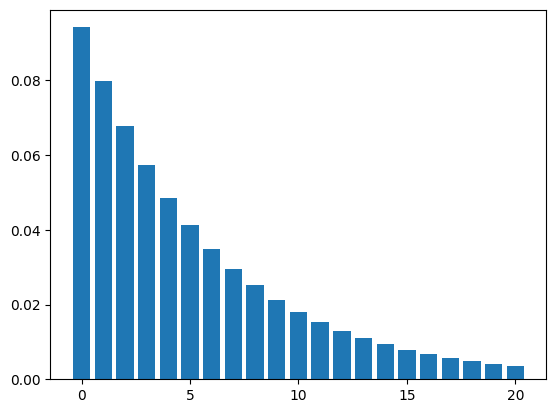

In [21]:
plt.figure()
plt.bar([i for i in range(0, len(ar_weights))], ar_weights)
plt.show()

In [22]:
np.save(f'../models/{symbol}', ar_weights)

In [23]:
signals = generate_signals(train_data, ar_weights)

In [24]:
def sma(returns, window):
    signals = []
    for i in range(len(returns)):
        if i < window:
            signals.append(0)  # Not enough data to calculate SMA
        else:
            current_sma = sum(returns[i-window:i]) / window
            prev_sma = sum(returns[i-window-1:i-1]) / window
            if current_sma > prev_sma:
                signals.append(current_sma)  # SMA rising
            elif current_sma < prev_sma:
                signals.append(current_sma)  # SMA falling
            else:
                signals.append(0)  # No change
    return signals

sma_sig = sma(np.asarray(train_data['returns'].reset_index(drop=True)), 4)

In [25]:
signals

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 np.float64(0.029024845812649407),
 np.float64(-0.05571690358567005),
 np.float64(-0.05903367985871724),
 np.float64(-0.021827631359392974),
 np.float64(-0.07866588423702785),
 np.float64(0.006986735955227309),
 np.float64(0.05736971915519985),
 np.float64(0.061219055791984826),
 np.float64(-0.0042662916462464714),
 np.float64(-0.04483007920401738),
 np.float64(-0.12473296348480489),
 np.float64(-0.07209862759098576),
 np.float64(-0.09096202473588522),
 np.float64(-0.12520369310566373),
 np.float64(0.08619220513459235),
 np.float64(-0.08562365491819485),
 np.float64(-0.03238906857888323),
 np.float64(-0.008536309946378155),
 np.float64(-0.04744332360874987),
 np.float64(-0.0843318369271009),
 np.float64(-0.13463570115180254),
 np.float64(-0.12195844759350045),
 np.float64(-0.06965374828389245),
 np.float64(-0.09394542011002978),
 np.float64(-0.20789843218602277),
 np.

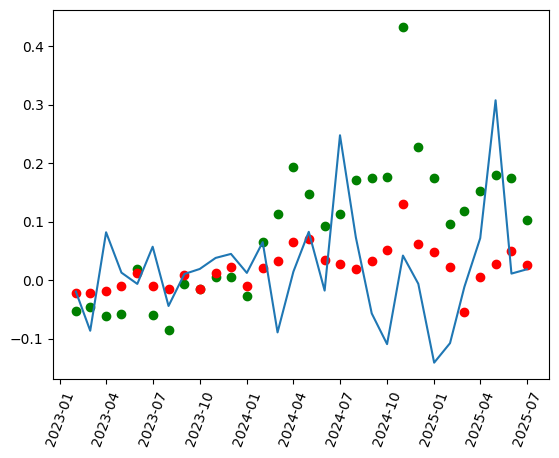

In [26]:
plt.figure()
plt.plot(data['date'][-30:], data['returns'][-30:])
plt.scatter(data['date'][-30:], signals[-30:], color='green')
plt.scatter(data['date'][-30:], sma_sig[-30:], color='red')
#plt.vlines(sell_dates[-30:], -0.05, 0.05, color='red')
plt.xticks(rotation=70)
plt.show()

In [27]:
buy_dates, sell_dates = get_action_dates(train_data, signals)


c:\Users\adity\markov-switching-model-trading\src\trend.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_dates.append(data['date'][i])
c:\Users\adity\markov-switching-model-trading\src\trend.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sell_dates.append(data['date'][i])


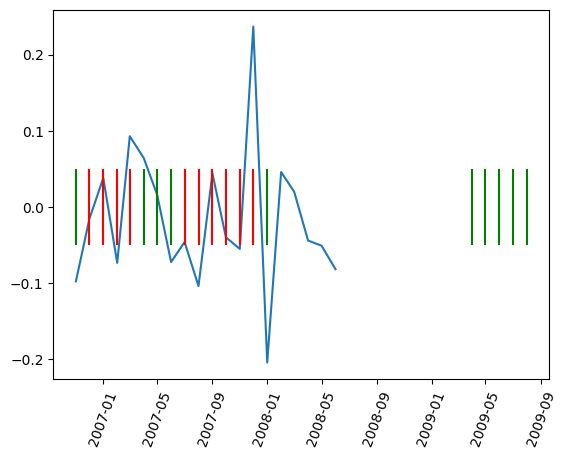

In [28]:
plot_actions(train_data, buy_dates, sell_dates, signals)

In [29]:
test_signals = generate_signals(test_data, ar_weights)

In [30]:
test_buy_dates, test_sell_dates = get_action_dates(test_data, test_signals)

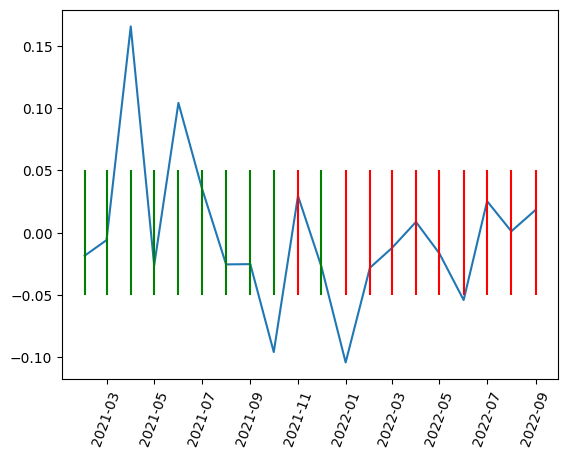

In [31]:
plot_actions(test_data, test_buy_dates, test_sell_dates, test_signals)